In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Import our custom modules
from src.data_generator import generate_sales_data
from src.feature_engineering import create_features
from src.model_trainer import train_linear_regression, train_random_forest, train_final_model, save_model
from src.evaluation import evaluate_model, perform_time_series_cv, plot_predictions
from src.business_value import calculate_business_value_by_month

# Define file paths session_1_sales_forecasting\implement\data\super_store_sales\sales_by_order_date.csv
DATA_DIR = 'data/super_store_sales'
MODEL_DIR = 'models'
DATA_FILE = os.path.join(DATA_DIR, 'sales_by_order_date_m.csv')
MODEL_FILE = os.path.join(MODEL_DIR, 'super_store_forecaster_m.pkl')

# Generate and load data
# generate_sales_data(DATA_FILE)
df = pd.read_csv(DATA_FILE, parse_dates=['date'])
df.set_index('date', inplace=True)
print('Columns in the dataframe:')
print(df.columns)
print('First 5 rows of the dataframe:')
print(df.head())

# Plot the raw data
print('Plotting the raw data...')
plt.style.use('seaborn-v0_8-whitegrid')
df['daily_revenue'].plot(figsize=(15, 6), title="Super Store - Monthly Revenue Historical Data")
plt.ylabel('Monthly Revenue ($)')
plt.show()


Columns in the dataframe:
Index(['daily_revenue'], dtype='object')
First 5 rows of the dataframe:
            daily_revenue
date                     
2015-01-01       14205.71
2015-02-01        4519.89
2015-03-01       55205.80
2015-04-01       27906.86
2015-05-01       23644.30
Plotting the raw data...


In [13]:
featured_df = create_features(df.reset_index())
print("Columns in our new dataset:")
print(featured_df.columns)
print("\nFirst 5 rows of the new data:")
print(featured_df.head())

# Save the featured dataframe to a csv file
FEATURED_DATA_FILE = os.path.join(DATA_DIR, 'super_store_sales_featured.csv')
featured_df.to_csv(FEATURED_DATA_FILE, index=False)
print(f"\nFeatured data saved to {FEATURED_DATA_FILE}")


Columns in our new dataset:
Index(['daily_revenue', 'day_of_week', 'month', 'year', 'quarter',
       'day_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7',
       'rolling_mean_30'],
      dtype='object')

First 5 rows of the new data:
            daily_revenue  day_of_week  month  year  quarter  day_of_year  \
date                                                                        
2017-07-01       38320.78            5      7  2017        3          182   
2017-08-01       30542.20            1      8  2017        3          213   
2017-09-01       69193.39            4      9  2017        3          244   
2017-10-01       59583.03            6     10  2017        4          274   
2017-11-01       79066.50            2     11  2017        4          305   

            day_of_week_sin  day_of_week_cos  month_sin     month_cos  \
date                                                                    


In [14]:
# lr_model, X_test_lr, y_test_lr = train_linear_regression(featured_df)
lr_model, X_test_lr, y_test_lr = train_linear_regression(featured_df, test_size=5)
lr_results = evaluate_model(lr_model, X_test_lr, y_test_lr)
plot_predictions(lr_results, title="Linear Regression Model - Actual vs. Predicted Monthly Revenue (Test Set)")

# Save Linear Regression results
LR_RESULTS_FILE = os.path.join(DATA_DIR, 'linear_regression_predictions.csv')
lr_results.to_csv(LR_RESULTS_FILE, index=True)
print(f"Linear Regression predictions saved to {LR_RESULTS_FILE}")


Training Linear Regression model...
Training complete.
Model Evaluation Results:
Mean Absolute Error (MAE): $24113.93
Root Mean Squared Error (RMSE): $28116.76
------------------------------
Interpretation:
On average, the model's predictions are off by about $24113.93.
RMSE is higher because it penalizes larger errors more heavily.


Linear Regression predictions saved to data/super_store_sales\linear_regression_predictions.csv


Training Random Forest with data shape: (13, 14)
Model training completed.
Model Evaluation Results:
Mean Absolute Error (MAE): $22168.70
Root Mean Squared Error (RMSE): $25880.81
------------------------------
Interpretation:
On average, the model's predictions are off by about $22168.70.
RMSE is higher because it penalizes larger errors more heavily.


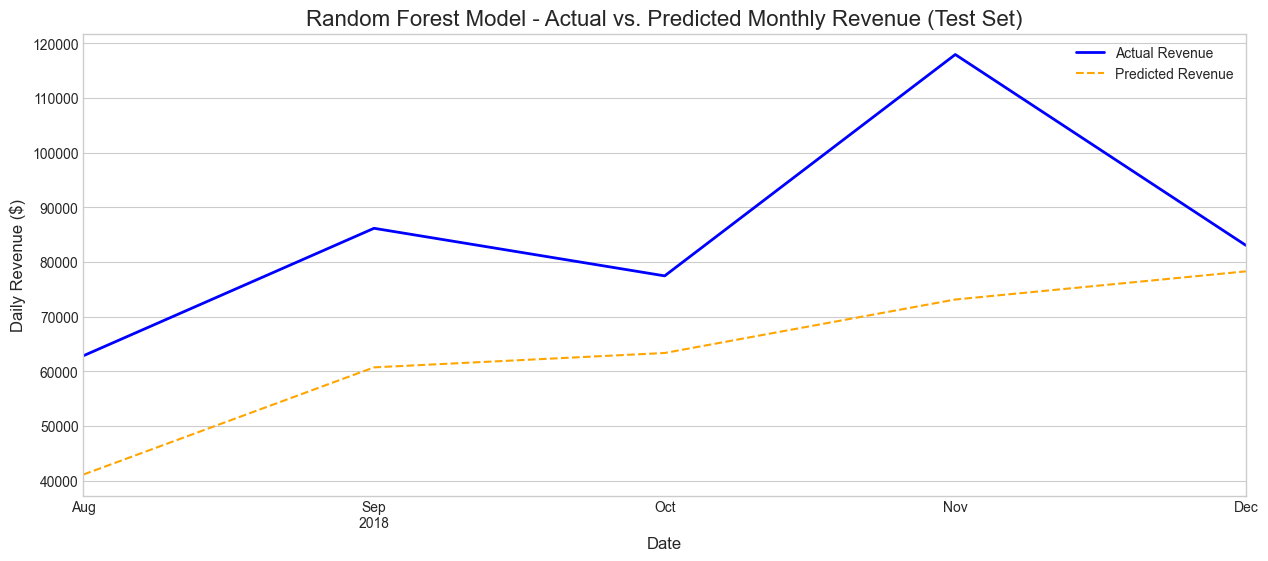

Random Forest predictions saved to data/super_store_sales\random_forest_predictions.csv


In [15]:
# rf_model, X_test_rf, y_test_rf = train_random_forest(featured_df)
rf_model, X_test_rf, y_test_rf = train_random_forest(featured_df, test_size=5)
rf_results = evaluate_model(rf_model, X_test_rf, y_test_rf)
plot_predictions(rf_results, title="Random Forest Model - Actual vs. Predicted Monthly Revenue (Test Set)")

# Save Random Forest results
RF_RESULTS_FILE = os.path.join(DATA_DIR, 'random_forest_predictions.csv')
rf_results.to_csv(RF_RESULTS_FILE, index=True)
print(f"Random Forest predictions saved to {RF_RESULTS_FILE}")


In [16]:
print("--- Running CV for Linear Regression ---")
lr_cv_model = LinearRegression()
lr_cv_results = perform_time_series_cv(lr_cv_model, featured_df)

# Save Linear Regression CV results
LR_CV_RESULTS_FILE = os.path.join(DATA_DIR, 'linear_regression_cv_predictions.csv')
# lr_cv_results.to_csv(LR_CV_RESULTS_FILE, index=True)
print(f"Linear Regression CV predictions saved to {LR_CV_RESULTS_FILE}")


--- Running CV for Linear Regression ---
Performing Time Series Cross-Validation with 5 splits...
------------------------------------------------------------
Fold 1/5 | Train: 3 | Test: 3 | MAE: $32684.46 | RMSE: $35338.58
Fold 2/5 | Train: 6 | Test: 3 | MAE: $129951.86 | RMSE: $132737.16
Fold 3/5 | Train: 9 | Test: 3 | MAE: $27007.81 | RMSE: $30018.21
Fold 4/5 | Train: 12 | Test: 3 | MAE: $158870.04 | RMSE: $159460.44
Fold 5/5 | Train: 15 | Test: 3 | MAE: $51997.07 | RMSE: $64061.27
------------------------------------------------------------
Average CV MAE: $80102.25
Average CV RMSE: $84323.13
Linear Regression CV predictions saved to data/super_store_sales\linear_regression_cv_predictions.csv


In [17]:
print("\n--- Running CV for Random Forest ---")
rf_cv_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_cv_results = perform_time_series_cv(rf_cv_model, featured_df)

# Save Random Forest CV results
RF_CV_RESULTS_FILE = os.path.join(DATA_DIR, 'random_forest_cv_predictions.csv')
# rf_cv_results.to_csv(RF_CV_RESULTS_FILE, index=True)
print(f"Random Forest CV predictions saved to {RF_CV_RESULTS_FILE}")



--- Running CV for Random Forest ---
Performing Time Series Cross-Validation with 5 splits...
------------------------------------------------------------
Fold 1/5 | Train: 3 | Test: 3 | MAE: $30534.76 | RMSE: $33149.67
Fold 2/5 | Train: 6 | Test: 3 | MAE: $23814.47 | RMSE: $28905.70
Fold 3/5 | Train: 9 | Test: 3 | MAE: $6553.07 | RMSE: $7066.37
Fold 4/5 | Train: 12 | Test: 3 | MAE: $17370.18 | RMSE: $19530.65
Fold 5/5 | Train: 15 | Test: 3 | MAE: $17192.47 | RMSE: $24374.83
------------------------------------------------------------
Average CV MAE: $19092.99
Average CV RMSE: $22605.45
Random Forest CV predictions saved to data/super_store_sales\random_forest_cv_predictions.csv


In [18]:
final_model = train_final_model(featured_df, model_type='rf')  # model_type can be 'rf' (Random Forest) or 'lr' (Linear Regression)
save_model(final_model, MODEL_FILE)


Training final RF model on entire dataset (shape: (18, 14))...
Final model training completed.
Model saved successfully to models\super_store_forecaster_m.pkl


In [19]:
# Add 'error' column for monthly business value calculation
rf_cv_results['error'] = rf_cv_results['actual_revenue'] - rf_cv_results['predicted_revenue']
calculate_business_value_by_month(rf_cv_results)


Monthly Strategic Business Value Analysis (Estimated)
-------------------------------------------------------
Assumptions:
  - Cost of monthly overstocking (excess inventory/planning): 12.0% of over-predicted revenue
  - Cost of monthly understocking (missed strategic ops): 20.0% of under-predicted revenue
  - 'Without AI' monthly planning has 10.0% higher error rate
-------------------------------------------------------
Average Monthly Cost of Prediction Errors with AI Model: $3,332.72
Estimated Monthly Cost of Errors without AI Model: $3,665.99
-------------------------------------------------------
Estimated Monthly Savings with AI Forecasting: $333.27
Estimated Annual Savings with AI Forecasting: $3,999.26
-------------------------------------------------------

Monthly Strategic Planning Benefits:
‚Ä¢ Enhanced seasonal inventory planning and supplier negotiations
‚Ä¢ Improved budget allocation and financial planning accuracy
‚Ä¢ Data-driven marketing campaigns and promotional str

In [20]:
# Import the predictor module
from src.predictor import load_model, predict_future_monthly_sales, plot_predictions_with_history, summarize_predictions

# Load the saved model
loaded_model = load_model(MODEL_FILE)

# Use the original DataFrame with date column for prediction
df_for_prediction = df.reset_index()

# Predict the next 5 months using the proper monthly function
print("üîÆ Generating 5-month revenue forecast for Super Store...")
future_predictions = predict_future_monthly_sales(loaded_model, df_for_prediction, months_ahead=5)

print(f"\n‚úÖ Successfully generated predictions for {len(future_predictions)} months!")
print("\nAll 5 month predictions:")
print(future_predictions.to_string(index=False))


Model loaded successfully from models\super_store_forecaster_m.pkl
üîÆ Generating 5-month revenue forecast for Super Store...

‚úÖ Successfully generated predictions for 5 months!

All 5 month predictions:
      date  predicted_revenue
2019-01-01         53237.5270
2019-02-01         77999.7304
2019-03-01         80492.1967
2019-04-01        103788.0418
2019-05-01         87357.9188


d:\LAM\01 PROJECTS\Sharing Sessions\session_1_sales_forecasting\implement\src\predictor.py:130: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_featured = future_featured.fillna(method='ffill')


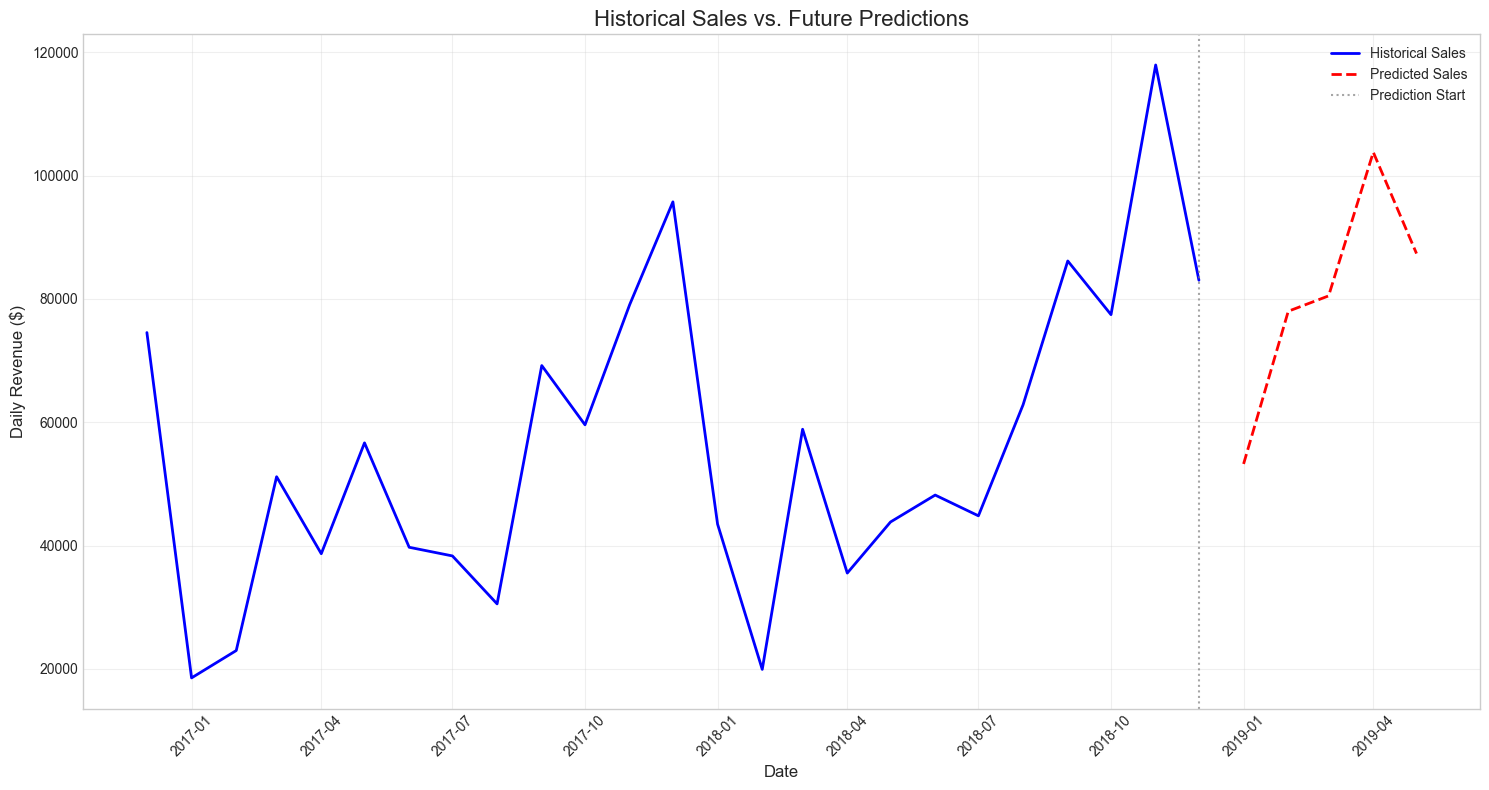

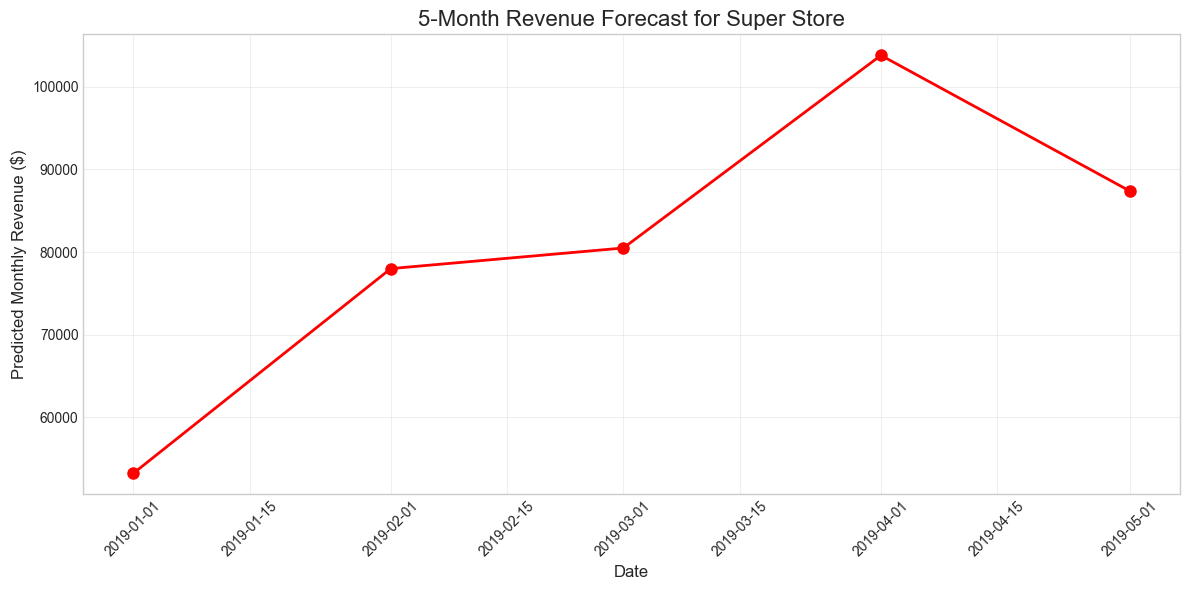

In [21]:
# Create a comprehensive plot showing historical data and future predictions
plot_predictions_with_history(df_for_prediction, future_predictions, days_to_show=25)

# Also create a zoomed-in view of just the prediction period
plt.figure(figsize=(12, 6))
plt.plot(future_predictions['date'], future_predictions['predicted_revenue'], 
         marker='o', color='red', linewidth=2, markersize=8)
plt.title("5-Month Revenue Forecast for Super Store", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Monthly Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
# Generate a comprehensive summary of the predictions
summarize_predictions(future_predictions)

# Save the predictions for business use
FUTURE_PREDICTIONS_FILE = os.path.join(DATA_DIR, 'super_store_5_month_forecast.csv')
future_predictions.to_csv(FUTURE_PREDICTIONS_FILE, index=False)
print(f"\nüíæ 5-month forecast saved to: {FUTURE_PREDICTIONS_FILE}")

# Create additional business-relevant analysis
print("\n" + "="*60)
print("üéØ ACTIONABLE BUSINESS INSIGHTS")
print("="*60)

# Find peak and low revenue months
max_month = future_predictions.loc[future_predictions['predicted_revenue'].idxmax()]
min_month = future_predictions.loc[future_predictions['predicted_revenue'].idxmin()]

print(f"\nüìà Peak Revenue Month:")
print(f"  ‚Ä¢ Date: {max_month['date'].strftime('%B %Y')}")
print(f"  ‚Ä¢ Predicted Revenue: ${max_month['predicted_revenue']:.2f}")

print(f"\nüìâ Lowest Revenue Month:")
print(f"  ‚Ä¢ Date: {min_month['date'].strftime('%B %Y')}")
print(f"  ‚Ä¢ Predicted Revenue: ${min_month['predicted_revenue']:.2f}")

# Calculate revenue variance for strategic planning
revenue_std = future_predictions['predicted_revenue'].std()
revenue_mean = future_predictions['predicted_revenue'].mean()
cv = (revenue_std / revenue_mean) * 100

print(f"\nüìä Variability Insights:")
print(f"  ‚Ä¢ Revenue Standard Deviation: ${revenue_std:.2f}")
print(f"  ‚Ä¢ Coefficient of Variation: {cv:.1f}%")

if cv < 10:
    print("  ‚Üí Low variability: Stable monthly planning possible")
elif cv < 20:
    print("  ‚Üí Moderate variability: Plan for seasonal fluctuation")
else:
    print("  ‚Üí High variability: Consider flexible monthly strategies")

# Seasonal analysis
print(f"\nüóìÔ∏è Seasonal Trends:")
for i, row in future_predictions.iterrows():
    month_name = row['date'].strftime('%B')
    if row['predicted_revenue'] > revenue_mean:
        trend = "üìà Above Average"
    else:
        trend = "üìâ Below Average"
    print(f"  ‚Ä¢ {month_name}: ${row['predicted_revenue']:.2f} ({trend})")


üîÆ Future Sales Forecast Summary
Prediction Period: 2019-01-01 to 2019-05-01
Number of Days: 5

üìä Revenue Predictions:
  ‚Ä¢ Average Daily Revenue: $80575.08
  ‚Ä¢ Minimum Daily Revenue: $53237.53
  ‚Ä¢ Maximum Daily Revenue: $103788.04
  ‚Ä¢ Total Predicted Revenue: $402875.41

üìà Weekly Breakdown:
  ‚Ä¢ Week 1: Avg $53237.53/day, Total $53237.53
  ‚Ä¢ Week 5: Avg $77999.73/day, Total $77999.73
  ‚Ä¢ Week 9: Avg $80492.20/day, Total $80492.20
  ‚Ä¢ Week 14: Avg $103788.04/day, Total $103788.04
  ‚Ä¢ Week 18: Avg $87357.92/day, Total $87357.92

üíæ 5-month forecast saved to: data/super_store_sales\super_store_5_month_forecast.csv

üéØ ACTIONABLE BUSINESS INSIGHTS

üìà Peak Revenue Month:
  ‚Ä¢ Date: April 2019
  ‚Ä¢ Predicted Revenue: $103788.04

üìâ Lowest Revenue Month:
  ‚Ä¢ Date: January 2019
  ‚Ä¢ Predicted Revenue: $53237.53

üìä Variability Insights:
  ‚Ä¢ Revenue Standard Deviation: $18295.01
  ‚Ä¢ Coefficient of Variation: 22.7%
  ‚Üí High variability: Consider fle